# 주요 라이브러리

In [6]:
import csv                          # CSV 파일 읽기/쓰기 위한 표준 모듈
import random                       # 난수 생성 (샘플 데이터 생성 시 활용)
import os                           # 파일 존재 여부 확인 등 OS 제어
import time                         # 시간 측정용 모듈
import pandas as pd                # 데이터프레임 기반 분석 (범용성 높음)
import polars as pl                # 고속 DataFrame 라이브러리 (Rust 기반)
from multiprocessing import Pool, cpu_count  # 병렬 처리용 프로세스 풀, CPU 수 확인
from io import StringIO            # 문자열을 파일 객체처럼 다룰 수 있음
import matplotlib.pyplot as plt    # 시각화를 위한 그래프 라이브러리
import numpy as np                 # 수치 계산용 (현재 사용되지 않지만 보조적으로 활용 가능)
import gc                          # 가비지 컬렉션 (메모리 수동 해제)

# 예제 데이터 준비

In [9]:
file_name = "large_data.csv"       # 생성할 CSV 파일 이름
num_rows = 5_000_000               # 500만 줄
num_columns = 10                   # 열은 10개
headers = [f"col_{i}" for i in range(num_columns)]  # 열 이름 리스트 생성

# 파일이 없을 때만 새로 생성
if not os.path.exists(file_name):
    print(f"{file_name} 파일 생성 중...")
    start_gen = time.time()
    
    with open(file_name, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # 헤더 작성

        for i in range(num_rows):
            # 짝수열: 문자열, 홀수열: 무작위 숫자
            row = [f"value_{i}_{j}" if j % 2 == 0 else random.randint(1, 1000000) for j in range(num_columns)]
            writer.writerow(row)

            # 상태 출력 (100만 줄마다)
            if (i + 1) % 1_000_000 == 0:
                print(f"{i + 1} 줄 작성 완료...")

    end_gen = time.time()
    print(f"{file_name} 파일 생성 완료. 소요 시간: {end_gen - start_gen:.2f} 초")

else:
    print(f"'{file_name}' 파일이 이미 존재합니다. 다시 생성하지 않습니다.")

large_data.csv 파일 생성 중...
1000000 줄 작성 완료...
2000000 줄 작성 완료...
3000000 줄 작성 완료...
4000000 줄 작성 완료...
5000000 줄 작성 완료...
large_data.csv 파일 생성 완료. 소요 시간: 21.96 초


# CSV 추출 속도 측정 함수

In [10]:
# (2-1) 순차 처리 방식 (단일 스레드)
def read_csv_sequential(file_path):
    """csv 모듈로 CSV 파일을 순차적으로 읽기"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)  # 헤더 건너뜀
        for row in reader:
            data.append(row)
    return data


# (2-2) 병렬 처리용 CSV 청크 처리 함수
def process_csv_chunk(chunk_lines):
    """청크 데이터를 받아 첫 번째 컬럼을 대문자로 변환 후 반환"""
    processed_rows = []
    f = StringIO('\n'.join(chunk_lines))  # 리스트를 하나의 문자열로 묶어 파일처럼 처리
    reader = csv.reader(f)
    for row in reader:
        if row:
            processed_rows.append([row[0].upper()] + row[1:])
    return processed_rows


# (2-2) 멀티프로세싱 방식으로 병렬 CSV 처리
def read_csv_parallel_multiprocessing(file_path, chunk_size_lines=100000):
    """파일을 청크 단위로 나눠 멀티프로세싱으로 처리"""
    all_data = []           # 최종 결과 저장 리스트
    pool = Pool(cpu_count())  # 사용 가능한 모든 CPU로 풀 생성

    temp_lines = []         # 청크 단위로 임시 저장
    line_count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        header = next(f)  # 첫 줄(헤더) 스킵

        for line in f:
            temp_lines.append(line.strip())
            line_count += 1
            if line_count % chunk_size_lines == 0:
                # 청크를 병렬 처리로 전송
                all_data.append(pool.apply_async(process_csv_chunk, (temp_lines,)))
                temp_lines = []

        # 마지막 청크 처리
        if temp_lines:
            all_data.append(pool.apply_async(process_csv_chunk, (temp_lines,)))

    pool.close()
    pool.join()

    # 각 프로세스 결과 수집
    final_processed_data = []
    for result in all_data:
        final_processed_data.extend(result.get())

    return final_processed_data

# 각 방식별 시간 측정 및 출력

In [11]:
# 결과 저장 변수 초기화
sequential_time = 0
multiprocessing_time = 0
pandas_time = 0
polars_time = 0
file_name = "large_data.csv"       # 불러올 CSV 파일 이름

if os.path.exists(file_name):

    # 🔸 (3-1) 단일 스레드 방식
    print("--- 단일 스레드 CSV 추출 (csv 모듈) 시작 ---")
    start_time = time.time()
    extracted_data_sequential = read_csv_sequential(file_name)
    end_time = time.time()
    sequential_time = end_time - start_time
    print(f"단일 스레드 (csv 모듈) 추출 완료. 총 {len(extracted_data_sequential)} 줄, 소요 시간: {sequential_time:.2f} 초")
    del extracted_data_sequential  # 메모리 정리
    gc.collect()

    # 🔸 (3-2) 멀티프로세싱 방식
    print("\n--- 멀티프로세싱 CSV 추출 (multiprocessing + csv 모듈) 시작 ---")
    start_time = time.time()
    extracted_data_parallel_mp = read_csv_parallel_multiprocessing(file_name)
    end_time = time.time()
    multiprocessing_time = end_time - start_time
    print(f"멀티프로세싱 (csv 모듈) 추출 완료. 총 {len(extracted_data_parallel_mp)} 줄, 소요 시간: {multiprocessing_time:.2f} 초")
    del extracted_data_parallel_mp
    gc.collect()

    # 🔸 (3-3) pandas 활용
    print("\n--- Pandas를 이용한 CSV 추출 시작 ---")
    start_time = time.time()
    df_pandas = pd.read_csv(file_name)
    end_time = time.time()
    pandas_time = end_time - start_time
    print(f"Pandas 추출 완료. 총 {len(df_pandas)} 줄, 소요 시간: {pandas_time:.2f} 초")
    del df_pandas
    gc.collect()

    # 🔸 (3-4) polars 활용
    print("\n--- Polars를 이용한 CSV 추출 시작 ---")
    start_time = time.time()
    df_polars = pl.read_csv(file_name)
    end_time = time.time()
    polars_time = end_time - start_time
    print(f"Polars 추출 완료. 총 {len(df_polars)} 줄, 소요 시간: {polars_time:.2f} 초")
    del df_polars
    gc.collect()

else:
    print(f"'{file_name}' 파일이 없습니다. 먼저 파일을 생성해주세요.")


--- 단일 스레드 CSV 추출 (csv 모듈) 시작 ---
단일 스레드 (csv 모듈) 추출 완료. 총 5000000 줄, 소요 시간: 10.83 초

--- 멀티프로세싱 CSV 추출 (multiprocessing + csv 모듈) 시작 ---
멀티프로세싱 (csv 모듈) 추출 완료. 총 5000000 줄, 소요 시간: 16.02 초

--- Pandas를 이용한 CSV 추출 시작 ---
Pandas 추출 완료. 총 5000000 줄, 소요 시간: 7.11 초

--- Polars를 이용한 CSV 추출 시작 ---
Polars 추출 완료. 총 5000000 줄, 소요 시간: 0.20 초


# 추출 속도 비교 시각화

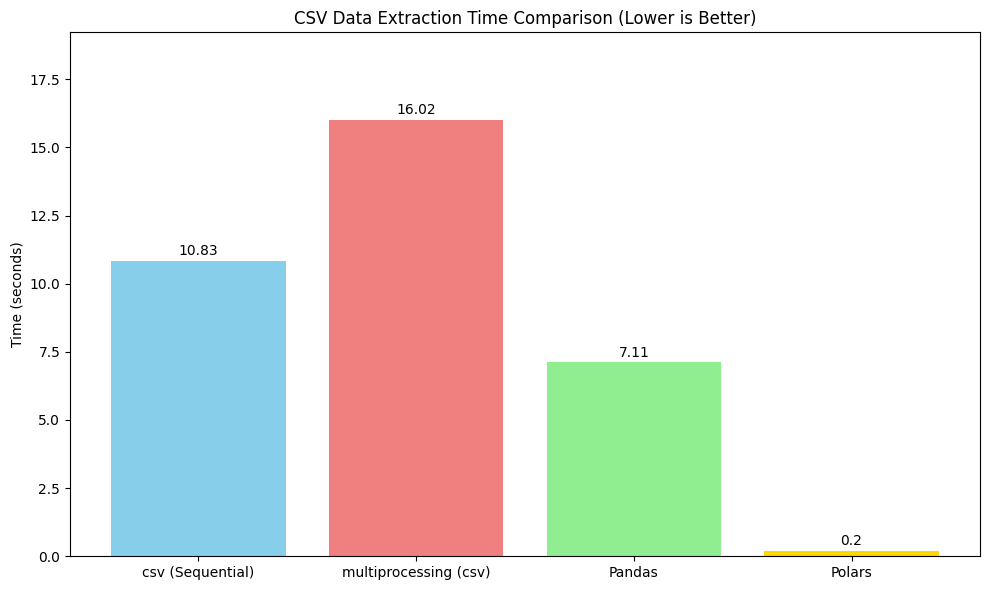

In [12]:
# x축 레이블
labels_csv = ['csv (Sequential)', 'multiprocessing (csv)', 'Pandas', 'Polars']
# 각각의 실행 시간
times_csv = [sequential_time, multiprocessing_time, pandas_time, polars_time]

# 모든 시간이 측정되었을 경우에만 시각화 진행
if all(time_val > 0 for time_val in times_csv):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    
    # 막대그래프 생성
    bars1 = ax1.bar(labels_csv, times_csv, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('CSV Data Extraction Time Comparison (Lower is Better)')
    ax1.set_ylim(0, max(times_csv) * 1.2)  # 여유 있게 y축 설정

    # 막대 위에 시간 값 표시
    for bar in bars1:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("\nCSV 추출 시간 데이터가 완전하지 않아 그래프를 그릴 수 없습니다.")